In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import iqr
import matplotlib.pyplot as plt

import dtale
import pywedge as pw

from altair import Chart, X, Y, repeat
import altair as alt
alt.data_transformers.disable_max_rows()
from utils.common import display_side_by_side

from utils.common_transformers import DateHandler, DateDiff, DTypeTransformer

import json
from IPython.display import display_html

from datetime import datetime

### Hypothesis Testing

train will be used to find patterns in data  
val will be used to validate those assumptions 

In [4]:
train = pd.read_csv("../data/train.csv")
val = pd.read_csv("../data/test.csv")
target_col = "Survived"

copy = train.copy()

# Exploratory Data Analysis

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,649,0,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.5500,NaN,S
1,296,0,1,"Lewy, Mr. Ervin G",male,NaN,0,0,PC 17612,27.7208,NaN,C
2,532,0,3,"Toufik, Mr. Nakli",male,NaN,0,0,2641,7.2292,NaN,C
3,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.5500,NaN,S
4,821,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S


In [6]:
pd.DataFrame(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  713 non-null    int64  
 1   Survived     713 non-null    int64  
 2   Pclass       713 non-null    int64  
 3   Name         713 non-null    object 
 4   Sex          713 non-null    object 
 5   Age          569 non-null    float64
 6   SibSp        713 non-null    int64  
 7   Parch        713 non-null    int64  
 8   Ticket       713 non-null    object 
 9   Fare         713 non-null    float64
 10  Cabin        162 non-null    object 
 11  Embarked     711 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 67.0+ KB


""


In [7]:
dtypes_mapping = {}

# cat_cols = ["Pclass","Sex","Embarked","SibSp","Parch"] # To apply after analysis
dtypes_mapping.update({"PassengerId":"str","Survived":"bool"})
# dtypes_mapping.update({i:"category" for i in cat_cols}) # To apply after analysis

train = DTypeTransformer(dtypes_mapping).fit_transform(train)

In [8]:
train.describe()

,Pclass,Age,SibSp,Parch,Fare
count,713.000000,569.000000,713.000000,713.000000,713.000000
mean,2.316971,29.442302,0.534362,0.380084,32.029627
std,0.843319,14.432367,1.163229,0.798521,51.127781
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.000000,0.000000,0.000000,7.925000
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,74.000000,8.000000,6.000000,512.329200


In [9]:
num_subset_cols = train.select_dtypes(include=np.number).columns

In [10]:
bounds = []
for col in num_subset_cols:
    param = iqr(train[col].dropna())*1.5
    upper = train[col].quantile(0.75) + param
    lower = train[col].quantile(0.25) - param
    bounds.append({"Column":col,"LowerBound":lower,"UpperBound":upper})
    
pd.DataFrame(bounds)

,Column,LowerBound,UpperBound
0,Pclass,0.5000,4.5000
1,Age,-7.0000,65.0000
2,SibSp,-1.5000,2.5000
3,Parch,0.0000,0.0000
4,Fare,-26.6875,65.6125


In [11]:
#df = DateHandler(["date"],date_format="%Y-%m-%d",drop_original_col=False).fit_transform(df)
#df = DateDiff(["date"],date_format="%Y-%m-%d",drop_original_col=False).fit_transform(df)

In [12]:
cat_cols = list(train.select_dtypes(exclude=np.number).columns)
extra_cat_cols = ["Pclass","SibSp","Parch"]
cat_cols.extend(extra_cat_cols)
vcs = []
mssgs = []
dtype_target_col = "num"  # num / cat
for col in cat_cols:
    if dtype_target_col == "num":
        agg_func = "mean"
        col_prefix = "% "
    else:
        agg_func = "median"
        col_prefix = "Mean"
        
    grouped = pd.DataFrame(train.groupby(col)[target_col].agg(agg_func))
    grouped.columns = [col_prefix + target_col]
    
    vc = pd.DataFrame(train[col].value_counts(dropna=False,normalize=True))
    vc.columns = ["Count %"]
    ans = pd.concat([vc.sort_index(),grouped.sort_index()],axis=1)
    ans.index.name = col
    ans.sort_values("Count %",ascending=False)
    vcs.append(ans.head(5))
    mssgs.append(f"Unique Categories : {len(vc)}")

display_side_by_side(vcs,mssgs)

,Count %,% Survived
PassengerId,,
10,0.001403,True
101,0.001403,False
102,0.001403,False
103,0.001403,False
104,0.001403,False
,Count %,% Survived
Survived,,
False,0.617111,False
True,0.382889,True


#### For Regression

In [ ]:
target_col = "Fare"
cat_cols = list(set(cat_cols).difference(set([target_col,])))
num_rows = len(cat_cols)

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(24,num_rows*12))
ax= axes.flatten()

for i in range(0,num_rows*2,2):
    col = cat_cols[i//2]
    a=pd.DataFrame(train.groupby(col)[target_col].median()).sort_values(target_col,ascending=False)
    a=a.reset_index()
    sns.set(font_scale = 2)
    sns_ax = sns.barplot(x=target_col,y=col,data=a,ax=ax[i],orient="h",order=list(a[col].values))
    sns_ax.set_xlabel(f'Median {target_col}',fontsize=20)
    sns_ax = sns.violinplot(x=target_col,y=col,data=train,orient="h",ax=ax[i+1],order=list(a[col].values))
    sns_ax.set_xlabel(f'Median {target_col}',fontsize=20)

  

In [ ]:
num_cols = list(set(num_subset_cols).difference(["Pclass","SibSp","Parch"]))
g=sns.pairplot(train,hue="Survived",vars=num_cols)
g.fig.set_size_inches(15,10)

In [ ]:
plt.ecdfploture(figsize = (20,10))
corr = train.corr()
mask = np.tril(corr)
sns.heatmap(corr,mask=mask,cmap="coolwarm",fmt=".2f",annot=True,vmin=-1,vmax=1,center=0,linewidth=0.2,)

In [ ]:
cols = list(set(num_cols).difference(set([target_col])))
num_rows = len(cols)

for i in range(0,num_rows):
    g=sns.jointplot(x=cols[i],y=target_col,data=train,kind="hex")
    g.fig.set_size_inches(15,7)


In [ ]:
# Chart(df).mark_line().encode(
#     x = "date:T",
#     y = "time_spent:Q"
# )

In [ ]:
# Chart(df).mark_rect().encode(
#     X("date(date):O"),
#     Y("month(date):O"),
#     alt.Color("time_spent:Q")
# )

## CDF Plots (Classification Problem)

In [ ]:
target_col = "Survived"

In [ ]:
num_rows = len(num_subset_cols)
fig, axes = plt.subplots(nrows=int(np.ceil(num_rows/2)), ncols=2, figsize=(25,num_rows*7))
ax= axes.flatten()

for i in range(0,num_rows):
    sns.ecdfplot(data=train,x=num_subset_cols[i],hue=target_col,ax=ax[i])


# Feature Engineering

In [42]:
df.to_json("../intermediate_data/basic_fe.json")

# Feature Engineering & Advanced EDA 

In [3]:
dtale.show(df,ignore_duplicate=True)

In [7]:
df=sns.load_dataset("tips")

In [10]:
mc=pw.Pywedge_Charts(df.dropna(),c=None,y="total_bill")
charts = mc.make_charts();

HTML(value='<h2>Pywedge Make_Charts </h2>')

HTML(value='<h4><em>Charts compiled by Pywedge make_charts </em></h4>')

## Discrete Target

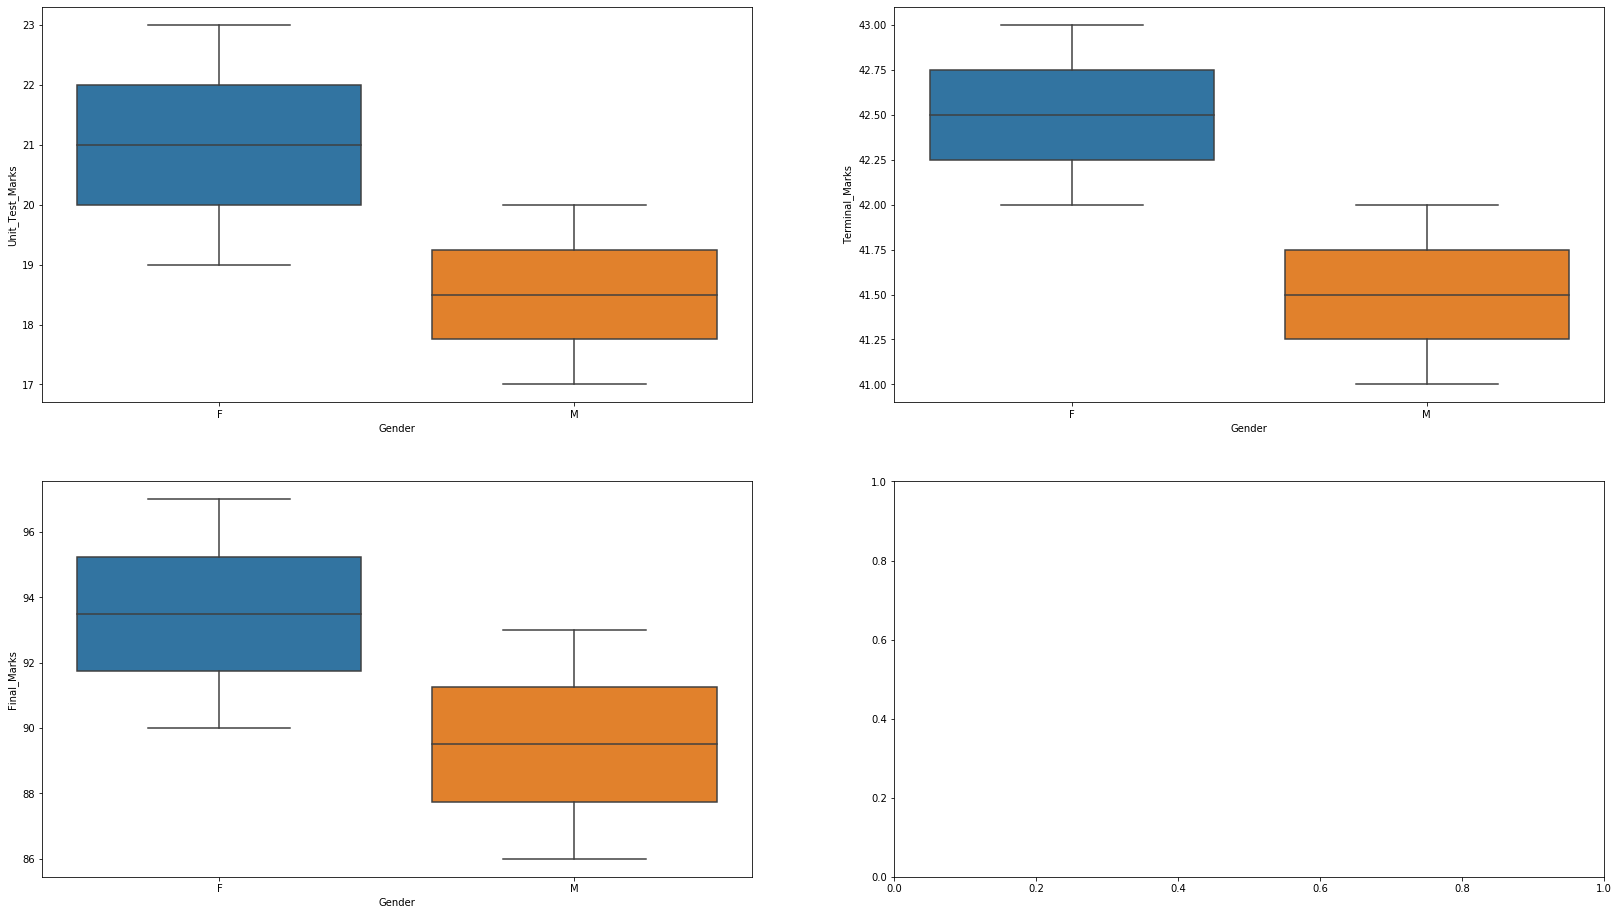

In [107]:
target_col = "Gender"
num_cols = df.select_dtypes(include=np.number)

num_rows = int(np.ceil(len(num_cols.columns) / 2))

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(28,num_rows*8))
ax= axes.flatten()
for index,col in enumerate(num_cols.columns,0):
    axes = ax[index]
    sns.boxplot(data=df,x=target_col,y=col,ax=axes,)
  

In [172]:
cat_cols_names = list(set(cat_cols.columns).difference(set([target_col])))
dfs = []
for index,col in enumerate(cat_cols_names,0):
    a = pd.DataFrame(df.groupby("Gender")[col].value_counts(dropna=False,normalize=True))
    a.columns=["% Count"]
    dfs.append(a)

In [173]:
display_side_by_side(*dfs)

% Count 
 
 
 Gender 
 Performance 
 
 
 
 
 
 F 
 NaN 
 0.5 
 
 
 A+ 
 0.5 
 
 
 M 
 A 
 0.5 
 
 
 B 
 0.5

## Continuous Target

### Normality Test

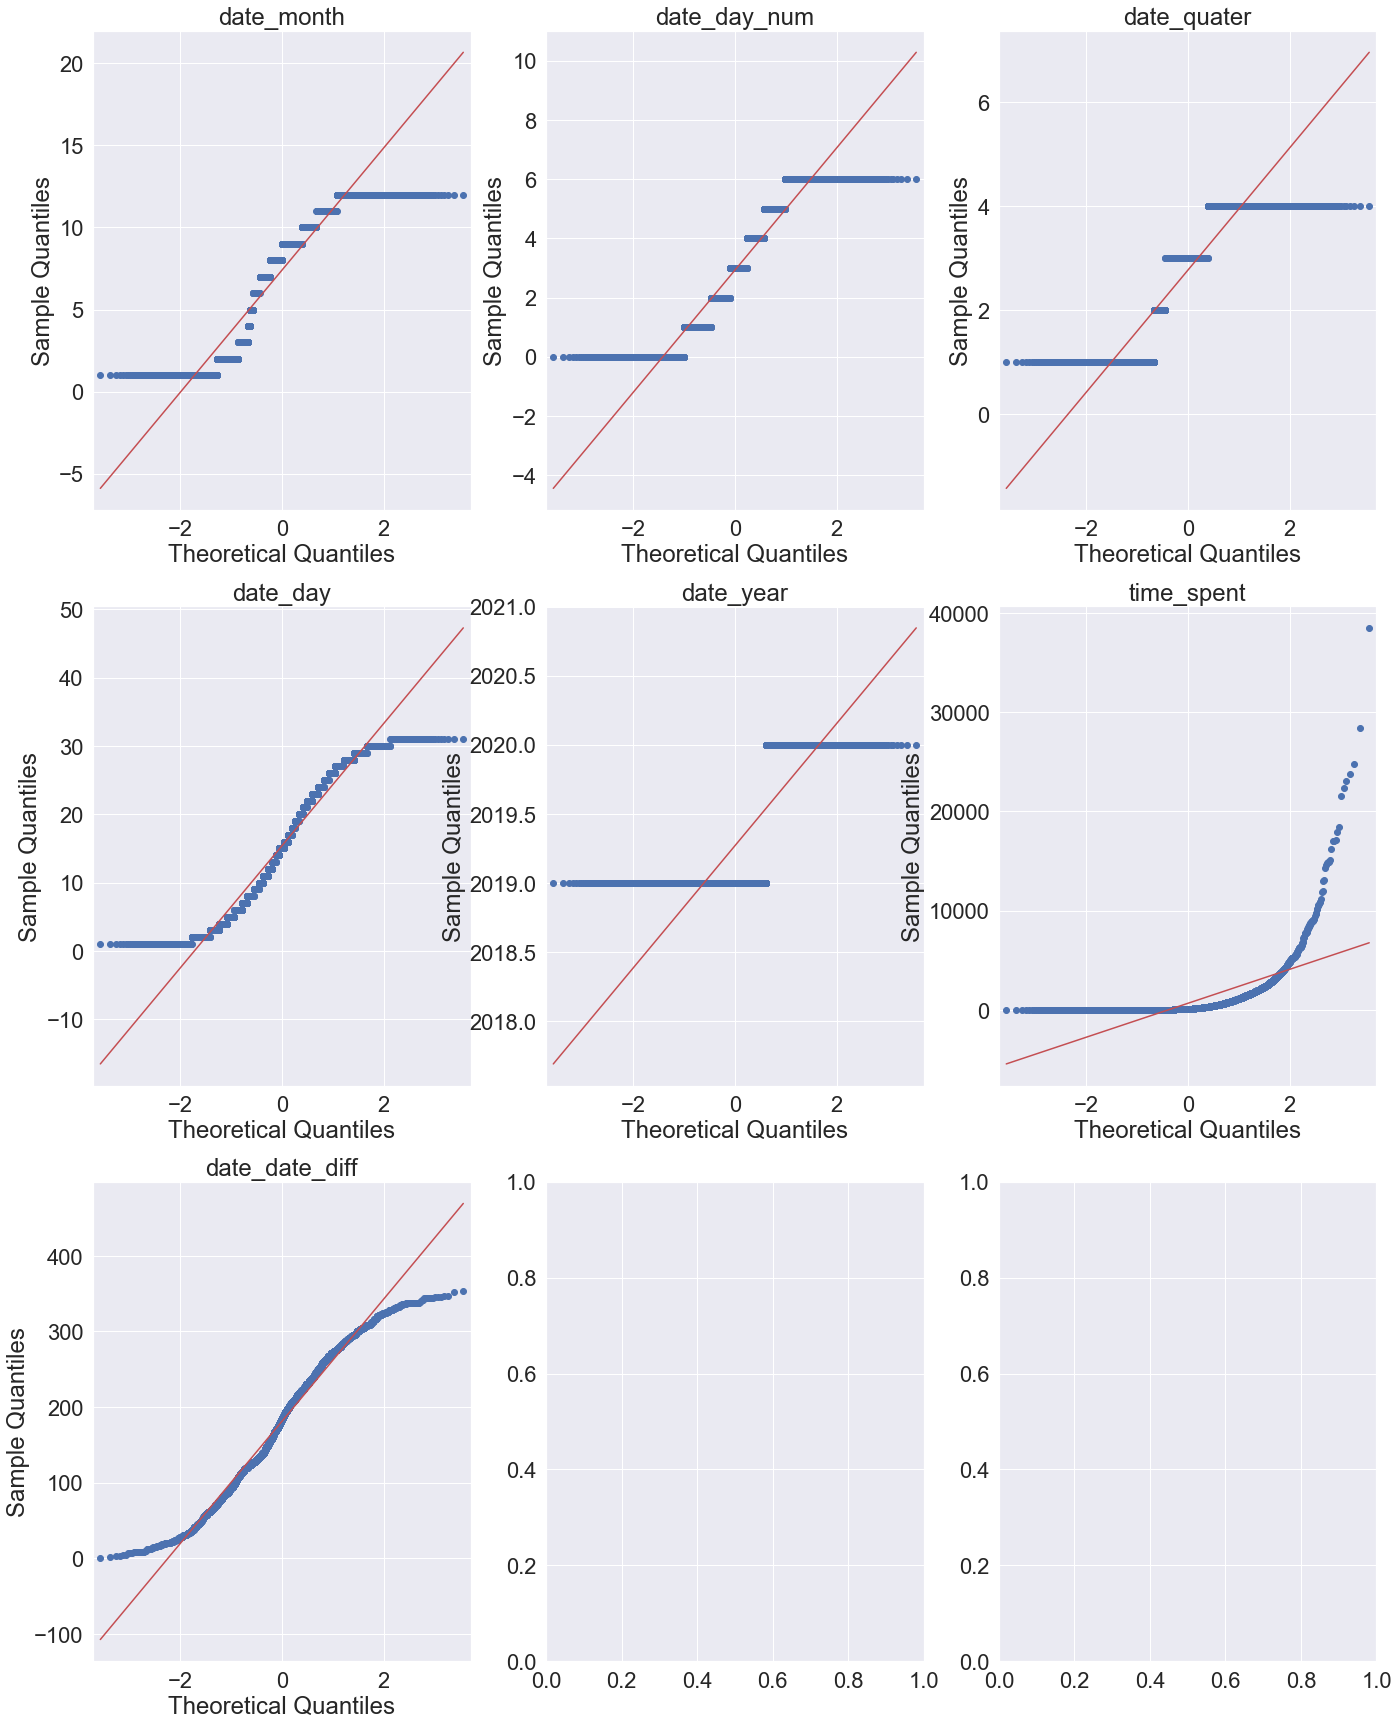

In [45]:
numeric= df.select_dtypes(include=[int,float])
num_numeric_cols = numeric.shape[1]
num_rows = int(np.ceil(num_numeric_cols / 3))

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(23,num_rows*10))
ax= axes.flatten()
for index,col in enumerate(numeric.columns,0):
    axes = ax[index]
    axes.set_title(col)
    qqplot(numeric[col], line='s',ax=axes)
    

# Feature Engineering